# Tomer and Nir 2024 IMU project
##### Function Declaration:

In [1]:
import numpy as np

from matplotlib import pyplot as plt
from snn.resonator import test_resonator_on_chirp, create_chirp_signal, trained_resonator, simple_resonator
import numpy as np
import matplotlib.pyplot as plt
import requests
import zipfile
import io
import numpy as np
import matplotlib.pyplot as plt

import test


# import DATA


In [2]:

# Function to download the zip file
def download_zip(url, save_path):
    response = requests.get(url)
    with open(save_path, 'wb') as f:
        f.write(response.content)

# Function to read data from 'imu.txt' into arrays for each column
def read_imu_data(zip_path):
    serial_num = []
    timestamps = []
    wx_values = []
    wy_values = []
    wz_values = []
    ax_values = []
    ay_values = []
    az_values = []

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open('imu.txt') as imu_file:
            next(imu_file)  # Skip the first line
            for line in imu_file:
                line = line.decode('utf-8').strip().split()
                sn, ts, wx, wy, wz, ax, ay, az = map(float, line)
                serial_num.append(sn)
                timestamps.append(ts)
                wx_values.append(wx)
                wy_values.append(wy)
                wz_values.append(wz)
                ax_values.append(ax)
                ay_values.append(ay)
                az_values.append(az)

    imu_data = np.zeros((len(ax_values),7))
    imu_data[:, 0] = timestamps
    imu_data[:, 1] = wx_values
    imu_data[:, 2] = wy_values
    imu_data[:, 3] = wz_values
    imu_data[:, 4] = ax_values
    imu_data[:, 5] = ay_values
    imu_data[:, 6] = az_values
    # Convert lists to numpy arrays
    serial_num = np.array(serial_num)
    timestamps = np.array(timestamps)
    wx_values = np.array(wx_values)
    wy_values = np.array(wy_values)
    wz_values = np.array(wz_values)
    ax_values = np.array(ax_values)
    ay_values = np.array(ay_values)
    az_values = np.array(az_values)
    print(imu_data)
    return serial_num, timestamps, wx_values, wy_values, wz_values, ax_values, ay_values, az_values, imu_data

## URL of the zip file
# zip_url = 'http://rpg.ifi.uzh.ch/datasets/uzh-fpv-newer-versions/v3/indoor_forward_9_davis_with_gt.zip'
zip_url = 'http://rpg.ifi.uzh.ch/datasets/uzh-fpv-newer-versions/v3/indoor_forward_3_davis_with_gt.zip'
## Path to save the downloaded zip file
zip_save_path = 'indoor_forward_3_davis_with_gt.zip'
# zip_save_path = 'indoor_forward_9_davis_with_gt.zip'
zip_save = "C:\FinalProject\indoor_forward_3_davis_with_gt.zip"
## Download the zip file
# download_zip(zip_url, zip_save_path)

## Read data from the 'imu.txt' file into arrays for each column
samp_num, timestamps, wx_values, wy_values, wz_values, ax_values, ay_values, az_values, imu_data = read_imu_data(zip_save)


[[ 1.54082024e+09 -6.49811264e-02 -5.32632218e-03 ...  6.89765625e-01
  -9.81958008e+00  1.00590820e+00]
 [ 1.54082024e+09 -6.49811264e-02 -5.32632218e-03 ...  6.94555664e-01
  -9.81479004e+00  1.01069824e+00]
 [ 1.54082024e+09 -6.39158620e-02 -4.26105748e-03 ...  7.08925781e-01
  -9.81479004e+00  1.01069824e+00]
 ...
 [ 1.54082033e+09 -9.69390554e-02  5.32632218e-03 ...  1.12086914e+00
  -9.80520996e+00  9.81958008e-01]
 [ 1.54082033e+09 -9.90695842e-02  4.26105748e-03 ...  1.07775879e+00
  -9.81958008e+00  1.05380859e+00]
 [ 1.54082033e+09 -9.80043198e-02  5.32632218e-03 ...  1.05859863e+00
  -9.84832031e+00  1.14481934e+00]]



# functions declaration


In [3]:
def plot_emitted_spikes(network, x_stop, nid=-1, label=None):
    spikes_neuron = network.neurons[nid]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(y_events[-1] + 1)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(500, dtype=int), 'valid')
    x = np.linspace(0, x_stop, len(y_spikes))
    plt.title('Resonator Output')
    plt.ylabel('Spikes per W500')
    plt.xlabel('Frequency')
    plt.plot(x, y_spikes)

# same, but adds legend (takes x2 more time)    
def plot_emitted_spikes_modified(network, x_stop, freq, nid=-1, label=None):
    spikes_neuron = network.neurons[nid]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(y_events[-1] + 1)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(500, dtype=int), 'valid')
    x = np.linspace(0, x_stop, len(y_spikes))

    # Plot the data and get a reference to the line object
    line, = plt.plot(x, y_spikes, label=f'Frequency: {freq}')

    # Set plot labels and title
    plt.title('Resonator Output')
    plt.ylabel('Spikes per 500')
    plt.xlabel('Frequency')

    # Create or update the legend
    lines, labels = plt.gca().get_legend_handles_labels()
    if f'Frequency: {freq}' not in labels:
        lines.append(line)
        labels.append(f'Frequency: {freq}')
    plt.legend(lines, labels)
# Call this function to display the plot without closing it
plt.show(block=False)
   
def resonator_output_spikes_on_chirp(my_resonator, freq0, clk_freq, save_figure=False,  neurons_log_potentials=None, neurons_log_spikes=None, step=None):
    neurons_log_potentials = neurons_log_potentials or []
    for i in neurons_log_potentials:
        my_resonator.log_membrane_potential(i)

    neurons_log_spikes = neurons_log_spikes or []
    for i in neurons_log_spikes:
        my_resonator.log_out_spikes(i)

    start_freq = 0
    spectrum = 4*freq0
    step = step or 1/clk_freq
    test_size = int(spectrum / step)

    print(start_freq, step, test_size, clk_freq)
    test_resonator_on_chirp(
        my_resonator,
        start_freq=start_freq,
        step=step,
        test_size=test_size,
        clk_freq=clk_freq
    )

    for i in neurons_log_potentials:
        membrane_neuron = my_resonator.neurons[i]
        y_membrane = membrane_neuron.membrane_potential_graph()
        x = np.linspace(start_freq, start_freq + spectrum, len(y_membrane))
        plt.title(f'membrane potential f={freq0}, neuron={i}')
        plt.plot(x, y_membrane)
        plt.show()

    spikes_window_size = 500
    for i in neurons_log_spikes:
        spikes_neuron = my_resonator.neurons[i]
        y_events = spikes_neuron.out_spikes()
        y_spikes = np.zeros(test_size)
        y_spikes[y_events] = 1
        y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
        x = np.linspace(start_freq, start_freq + spectrum, len(y_spikes))
        plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
        if save_figure:
            plt.savefig('plot.png', dpi=300, bbox_inches='tight')
            plt.close()
        else:
            plt.plot(x, y_spikes)
            plt.show()
            
def test_frequency(network, test_size=10_000_000, start_freq=0, step=1 / 200000, clk_freq=1536000):
    batch_size = 50_000
    shift = 0
    while test_size > 0:
        sine_size = min(batch_size, test_size)
        sine_wave, freqs = create_chirp_signal(sine_size, clk_freq, start_freq, step, shift)

        network.input_full_data(sine_wave)

        shift = freqs[-1]
        start_freq += sine_size * step
        test_size -= sine_size
             
def custom_resonator_output_spikes(resonator, freq0, clk_freq, sample_rate=1, step = None, save_figure=False, path=None, plot=True, c=None):
    resonator.log_out_spikes(-1)
    start_freq = freq0/2
    spectrum = freq0
    step = step or 1 / clk_freq / sample_rate
    test_size = int(spectrum / step)
    spikes_neuron = resonator.neurons[-1]

    spikes_neuron.membrane_sample_max_window = np.zeros(1).astype('float32')
    test_frequency(
        resonator,
        start_freq=start_freq,
        step=step,
        test_size=test_size,
        clk_freq=clk_freq
   )

    events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(events[-1] + 1)
    y_spikes[events] = 1

    if path is not None:
        np.savez_compressed(path, spikes=y_spikes)

    spikes_window_size = 500
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq + spectrum, len(y_spikes))
    # plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
    plt.plot(x, y_spikes, label=freq0, c=c)
    if save_figure:
        plt.savefig(f'../filters/clk_{clk_freq}/figures/f_{freq0:.3f}.PNG', bbox_inches='tight')
        plt.close()
    elif plot:
        plt.show()
        

#Parameters:
clk_freq=1536000
spectrum = 300
step = 1/20000  # To reduce running time, increase step
test_size = int(spectrum / step)

# Resonator Checks:
#### The main objective is to check that we have full coverage of the spectrum

30.5 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_30.5.json
Thetas:  [-37.124, -32.549, -29.814, -29.008] , Weights: [123.204, 50.851, 64.454, 59.25, 58.383] , Leakage Factor:   4 , Clock Frequency:  153600
f is:  30.5 f_clk = 153600 Leakage Period is: 49


<string>:3: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.


63.6 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_63.6.json
Thetas:  [-98.054, -70.205, -64.087, -57.686] , Weights: [294.356, 103.068, 140.527, 124.915, 116.543] , Leakage Factor:   4 , Clock Frequency:  153600
f is:  63.6 f_clk = 153600 Leakage Period is: 23
95.4 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_95.4.json
Thetas:  [-117.549, -100.74, -96.393, -85.843] , Weights: [387.993, 160.185, 197.341, 190.822, 177.199] , Leakage Factor:   4 , Clock Frequency:  153600
f is:  95.4 f_clk = 153600 Leakage Period is: 15
160 Type:  <class 'int'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_160.json
Thetas:  [-19.184, -17.323, -15.152, -15.803] , Weights: [63.808, 26.451, 34.141, 30.497, 31.678] , Leakage Factor:   4 , Clock Frequency:  1536000
f is:  163 f_clk = 1536000 Leakage Period is: 92


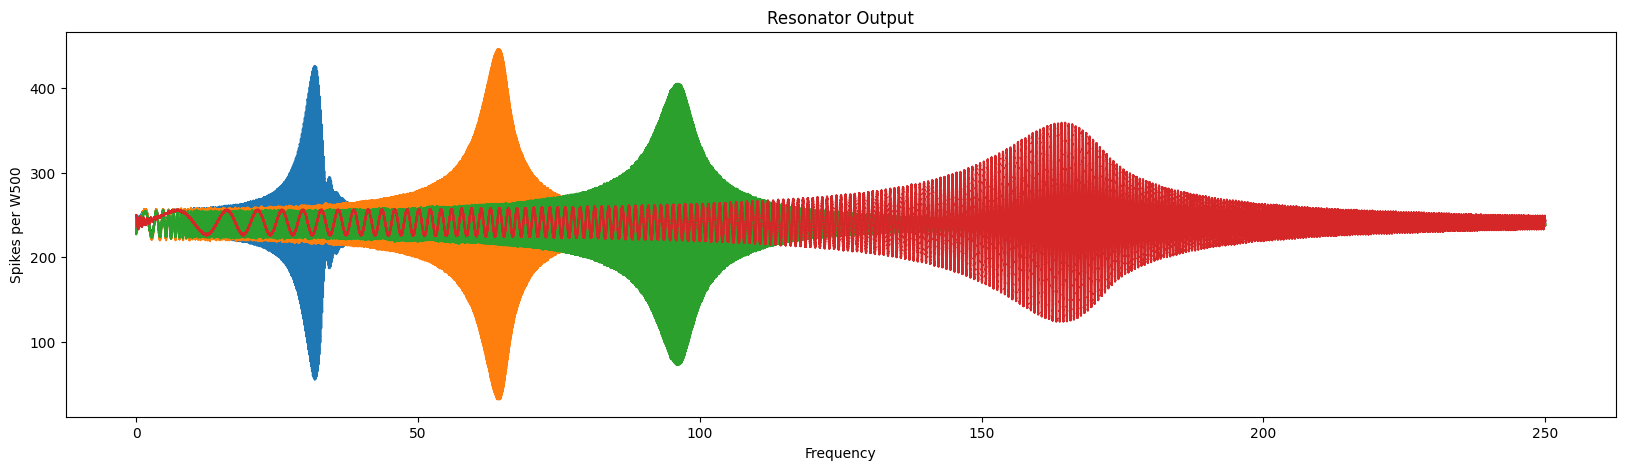

In [4]:
plt.figure(figsize=(20, 5))

#for one frequency:
resonators_freqs = [30.5,63.6,95.4,163]

#for an evenly spaced frequencies:
#resonators_freqs = [i for i in range(40,260,15)]

#for the exact location of the resonators:
#resonators_freqs = [6.94, 8.98, 10.5, 15.9, 19.5, 25, 30.5, 34.7, 40.2, 46.2,  52.6, 63.6, 69.4, 76.3, 89.8, 95.4, 110, 128, 130, 160, 175, 195, 221, 250]


spectrum = 250
for i, freq in enumerate(resonators_freqs):
    resonator = trained_resonator(freq0=freq)
    resonator.log_out_spikes(-1) # log the spikes emitted from the last neuron
    if freq < 10:
        step = 1/30000
        clk_freq = 15360
    elif 100 > freq >= 10:
        step = 1/30000
        clk_freq = 153600 
    else:
        step = 1/15000
        clk_freq = 1536000         
     
    test_size = int(spectrum / step)
    
    test_resonator_on_chirp(
        resonator,
        start_freq=0,
        test_size=test_size,
        clk_freq=clk_freq,
        step=step)
    plot_emitted_spikes(resonator, spectrum)
    #(do not release this line)modified takes x2 time, but shows legend:
    #plot_emitted_spikes_modified(resonator, spectrum, freq)
    


# dataset chirp


In [5]:
def test_resonator_on_dataset(network, dataset, amplifier=1):
   
    network.input_full_data(amplifier*dataset)
     

Original Data:
[2.62015137 2.6488916  2.67763184 ... 0.58438477 0.44068359 0.58438477]


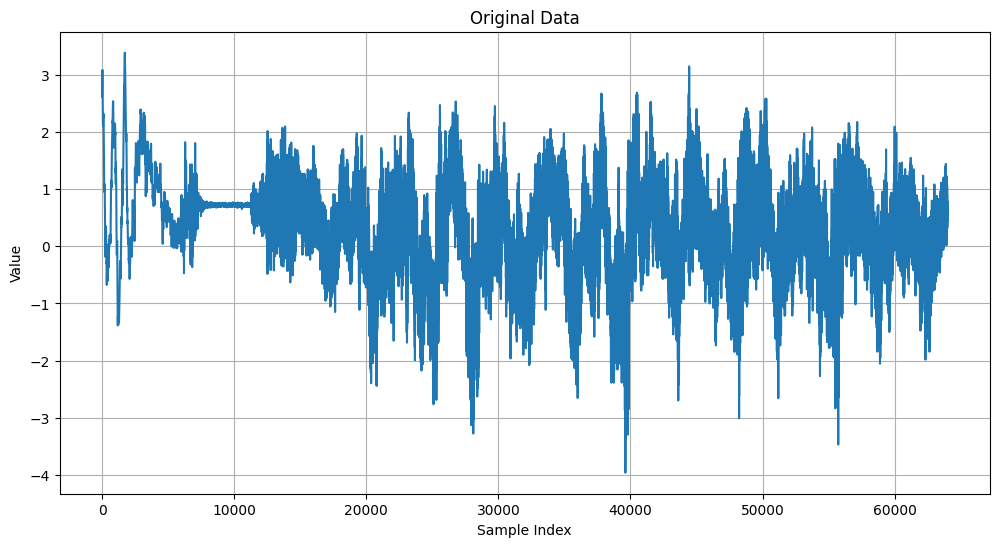

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a sample list of 62000 numbers (for example purposes, we use random numbers)
data = ax_values[16000:80000]

# Print the vector of values
print("Original Data:")
print(data)

# Plot the original data
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.title('Original Data')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()  

6.94 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_6.94.json
Thetas:  [-113.694, -77.332, -69.207, -62.432] , Weights: [334.262, 112.405, 154.573, 135.118, 126.891] , Leakage Factor:   4 , Clock Frequency:  15360
f is:  6.94 f_clk = 15360 Leakage Period is: 21
8.98 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_8.98.json
Thetas:  [-106.516, -93.167, -90.835, -81.611] , Weights: [359.026, 152.001, 182.454, 179.91, 167.481] , Leakage Factor:   4 , Clock Frequency:  15360
f is:  8.98 f_clk = 15360 Leakage Period is: 16
10.5 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_10.5.json
Thetas:  [-11.912, -11.103, -9.652, -9.996] , Weights: [42.046, 18.636, 21.913, 19.553, 20.16] , Leakage Factor:   4 , Clock Frequency:  153600
f is:  10.5 f_clk = 153600 Leakage Period is: 144
15.9 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_15.9.json
Thetas:

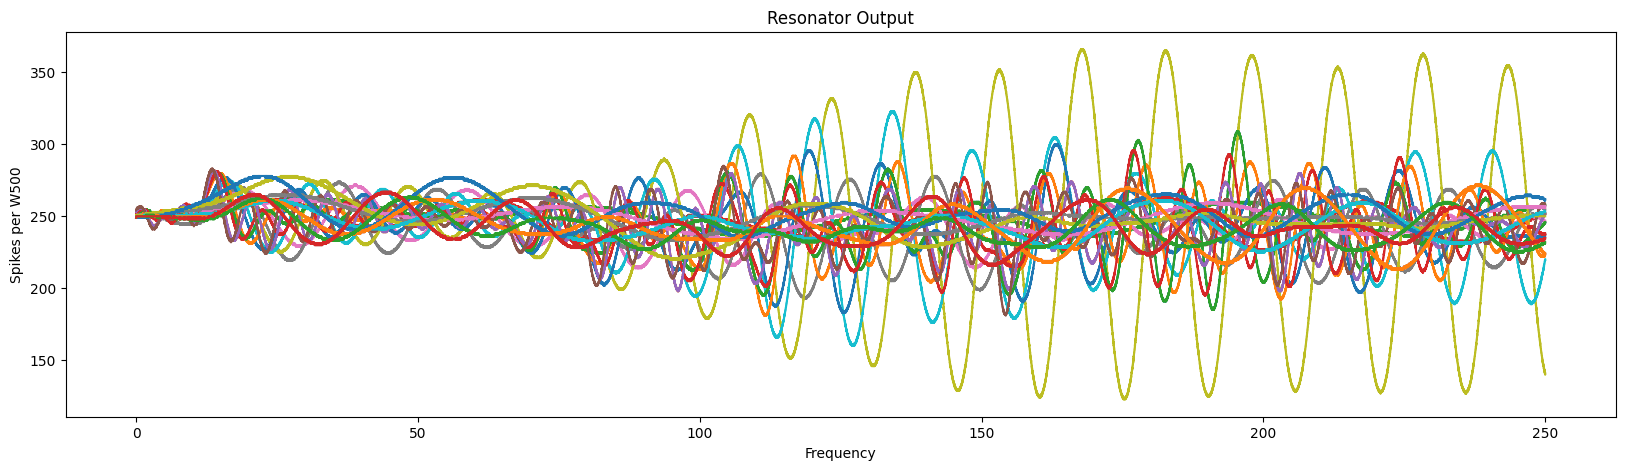

In [7]:

plt.figure(figsize=(20, 5))

#for one frequency:
# resonators_freqs = [30.5,63.6,95.4,163]

#for an evenly spaced frequencies:
#resonators_freqs = [i for i in range(40,260,15)]

#for the exact location of the resonators:
resonators_freqs = [6.94, 8.98, 10.5, 15.9, 19.5, 25, 30.5, 34.7, 40.2, 46.2,  52.6, 63.6, 69.4, 76.3, 89.8, 95.4, 110, 128, 130, 160, 175, 195, 221, 250]



spectrum = 250
for i, freq in enumerate(resonators_freqs):
    resonator = trained_resonator(freq0=freq)
    resonator.log_out_spikes(-1) # log the spikes emitted from the last neuron
    # if freq < 10:
    #     step = 1/30000
    #     clk_freq = 15360
    # elif 100 > freq >= 10:
    #     step = 1/30000
    #     clk_freq = 153600 
    # else:
    #     step = 1/15000
    #     clk_freq = 1536000         
     
    test_size = int(spectrum / step)
    
    test_resonator_on_dataset(
        resonator,
        ax_values[16000:80000])
    plot_emitted_spikes(resonator, spectrum)
    #(do not release this line)modified takes x2 time, but shows legend:
    #plot_emitted_spikes_modified(resonator, spectrum, freq)
    



# Spectogram Analysis



6.94 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_6.94.json
Thetas:  [-113.694, -77.332, -69.207, -62.432] , Weights: [334.262, 112.405, 154.573, 135.118, 126.891] , Leakage Factor:   4 , Clock Frequency:  15360
f is:  6.94 f_clk = 15360 Leakage Period is: 21
8.98 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_8.98.json
Thetas:  [-106.516, -93.167, -90.835, -81.611] , Weights: [359.026, 152.001, 182.454, 179.91, 167.481] , Leakage Factor:   4 , Clock Frequency:  15360
f is:  8.98 f_clk = 15360 Leakage Period is: 16
10.5 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_10.5.json
Thetas:  [-11.912, -11.103, -9.652, -9.996] , Weights: [42.046, 18.636, 21.913, 19.553, 20.16] , Leakage Factor:   4 , Clock Frequency:  153600
f is:  10.5 f_clk = 153600 Leakage Period is: 144
15.9 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_15.9.json
Thetas:

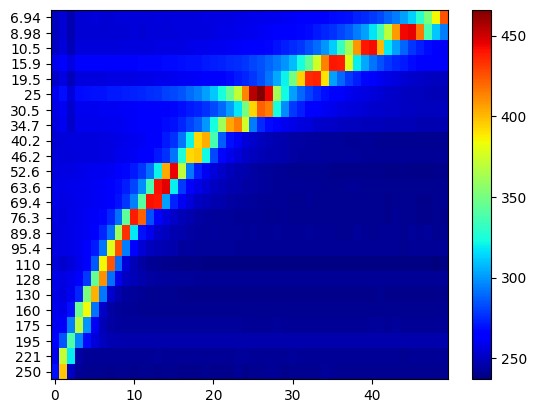

In [8]:

T =20.0
Fs =400.0
def generate_signal(freqs, T=20.0, Fs=400.0):
    # Number of samples per segment
    N = int(T * Fs)
    # Create a time array for one segment
    t = np.linspace(0.0, T, N, endpoint=False)
    # Initialize the signal array
    signal = np.array([])
    # Generate sinusoidal signal for each frequency and concatenate
    for freq in freqs:
        s = np.sin(freq * 2 * np.pi * t)
        signal = np.append(signal, s)
    signal1 = np.concatenate([signal])
    return signal1

def chirp_input_to_spectogram(network, x_stop, nid=-1, label=None):
    spikes_neuron = network.neurons[nid]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(y_events[-1] + 1)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(500, dtype=int), 'valid')
    return y_spikes

# Example usage
# freqs = [30.0, 60.0, 90.0, 120.0, 150.0, 180.0]
# sinus_signals = generate_signal(freqs) # output is one vector of N sine waves put one after the other


resonators_freqs = [6.94, 8.98, 10.5, 15.9, 19.5, 25, 30.5, 34.7, 40.2, 46.2,  52.6, 63.6, 69.4, 76.3, 89.8, 95.4, 110, 128, 130, 160, 175, 195, 221, 250]
# resonators_freqs = [6.94, 8.98, 10.5, 15.9, 19.5]
l = len(resonators_freqs)

chirp_output = []
spectrum = 250
for i, freq in enumerate(resonators_freqs):
    resonator_chirp = trained_resonator(freq0=freq)
    resonator_chirp.log_out_spikes(-1) # log the spikes emitted from the last neuron
    if freq < 10:
        clk_freq = 15360
    elif 100 > freq >= 10:
        clk_freq = 153600 
    else:
        clk_freq = 1536000         
     
    test_size = int(spectrum / step)
    test_resonator_on_chirp(
    resonator_chirp,
    start_freq=0,
    test_size=test_size,
    clk_freq=clk_freq,
    step=step)
    chirp_output.append(chirp_input_to_spectogram(resonator_chirp, spectrum))
    
num_frames = 50
min_value = len(min(chirp_output, key=len)) - (len(min(chirp_output, key=len))%num_frames)
print(min_value)
k= int(min_value/num_frames)
print(min_value/k)
print(chirp_output[0][:min_value])

reduced_chirp = []
for i in range(l):
    reduced_chirp.append(np.maximum.reduceat((chirp_output[i][:min_value]), np.arange(0, len((chirp_output[i][:min_value])), k)))
print('reduced_data size is:', np.shape(reduced_chirp))

spikegram = np.zeros((l, num_frames))
for i, resonator_output in enumerate(reduced_chirp):
    spikegram[i, :] = (reduced_chirp[i])



# Create the imshow plot
fig, ax = plt.subplots()
cax = ax.imshow(spikegram[::-1], cmap = 'jet', aspect='auto')

# Set the y-axis ticks and labels
ax.set_yticks(np.arange(len(resonators_freqs)))  # Set the number of ticks
ax.set_yticklabels(resonators_freqs)  # Set the labels

# Display the plot
plt.colorbar(cax)
plt.show()


## spiketogram for real dataset

250 Type:  <class 'int'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_250.json
Thetas:  [-30.365, -26.786, -24.465, -24.437] , Weights: [99.455, 40.538, 52.741, 48.947, 49.019] , Leakage Factor:   4 , Clock Frequency:  1536000
f is:  250 f_clk = 1536000 Leakage Period is: 60
221 Type:  <class 'int'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_221.json
Thetas:  [-26.511, -23.624, -21.416, -21.755] , Weights: [87.574, 36.152, 46.334, 42.9, 43.672] , Leakage Factor:   4 , Clock Frequency:  1536000
f is:  221 f_clk = 1536000 Leakage Period is: 68
195 Type:  <class 'int'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_195.json
Thetas:  [-23.292, -20.967, -18.739, -19.253] , Weights: [77.357, 32.09, 41.255, 37.596, 38.596] , Leakage Factor:   4 , Clock Frequency:  1536000
f is:  195 f_clk = 1536000 Leakage Period is: 77
175 Type:  <class 'int'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_175.json
Thetas:  [-24.442, -17.659, 

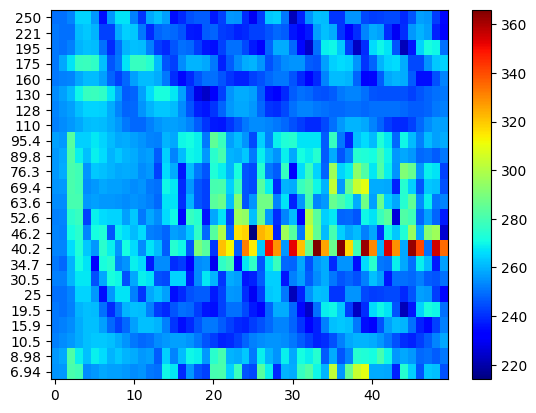

In [9]:
# %matplotlib qt
resonators_freqs_order = [6.94, 8.98, 10.5, 15.9, 19.5, 25, 30.5, 34.7, 40.2, 46.2,  52.6, 63.6, 69.4, 76.3, 89.8, 95.4, 110, 128, 130, 160, 175, 195, 221, 250]
# reversed_list = my_list[::-1]


# resonators_freqs = [6.94,40.2, 175, 195, 221, 250]

dataset_output = []
spectrum = 250
resonators_freqs = resonators_freqs_order[::-1]
for i, freq in enumerate(resonators_freqs):
    resonator = trained_resonator(freq0=freq)
    resonator.log_out_spikes(-1) # log the spikes emitted from the last neuron
    if freq < 10:
        clk_freq = 15360
    elif 100 > freq >= 10:
        clk_freq = 153600 
    else:
        clk_freq = 1536000         
     
    test_size = int(spectrum / step)
    test_resonator_on_dataset(resonator, ax_values[16000:80000])

    # test_resonator_on_dataset(resonator, ax_values[16000:80000])
    dataset_output.append(chirp_input_to_spectogram(resonator, spectrum))
  
l = len(resonators_freqs)
  
num_frames = 50
min_value = len(min(dataset_output, key=len)) - (len(min(dataset_output, key=len))%num_frames)
print(min_value)
k= int(min_value/num_frames)
print(min_value/k)
print(dataset_output[0][:min_value])

reduced_data = []
print('reduced_data size is:', np.size(reduced_data))
for i in range(l):
    reduced_data.append(np.maximum.reduceat((dataset_output[i][:min_value]), np.arange(0, len((dataset_output[i][:min_value])), k)))
print('reduced_data size is:', np.shape(reduced_data))

spikegram = np.zeros((l, num_frames))
for i, resonator_output in enumerate(reduced_data):
    spikegram[i, :] = (reduced_data[i])



# Create the imshow plot
fig, ax = plt.subplots()
cax = ax.imshow(spikegram, cmap = 'jet', aspect='auto')

# Set the y-axis ticks and labels
ax.set_yticks(np.arange(len(resonators_freqs)))  # Set the number of ticks
ax.set_yticklabels(resonators_freqs)  # Set the labels

# Display the plot
plt.colorbar(cax)
plt.show()

# FFT

# fft on chirp

# fft on data

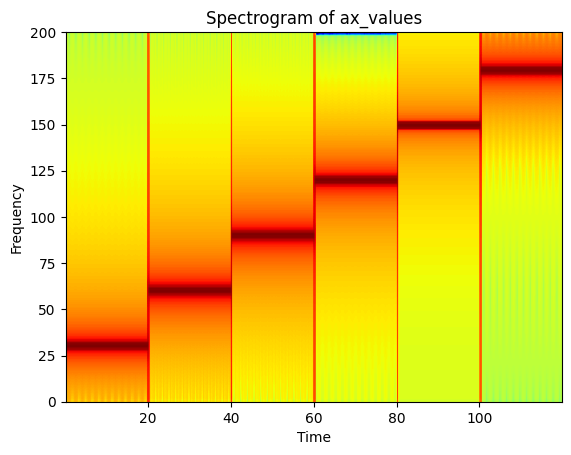

In [10]:

import numpy as np
import matplotlib.pyplot as plt
T =20.0
Fs =400
def generate_signal(freqs, T=20.0, Fs=400.0):
    # Number of samples per segment
    N = int(T * Fs)
    # Create a time array for one segment
    t = np.linspace(0.0, T, N, endpoint=False)
    # Initialize the signal array
    signal = np.array([])
    # Generate sinusoidal signal for each frequency and concatenate
    for freq in freqs:
        s = np.sin(freq * 2 * np.pi * t)
        signal = np.append(signal, s)
    signal1 = np.concatenate([signal])
    return signal1

def chirp_input_to_spectogram(network, x_stop, nid=-1, label=None):
    spikes_neuron = network.neurons[nid]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(y_events[-1] + 1)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(500, dtype=int), 'valid')
    return y_spikes

# Example usage
freqs = [30.0, 60.0, 90.0, 120.0, 150.0, 180.0]
sinus_signals = generate_signal(freqs) # output is one vector of N sine waves put one after the other



# Assuming ax_values is your signal and Fs is your sampling frequency
# Fs = 500  # Replace with your actual sampling frequency

# Create figure and axis
fig, ax = plt.subplots()

# Create the spectrogram
# ax.specgram(ax_values[16000:80000], Fs=Fs,cmap='jet')
ax.specgram(sinus_signals, Fs=Fs,cmap='jet')

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_title('Spectrogram of ax_values')

# Display the plot
plt.show()

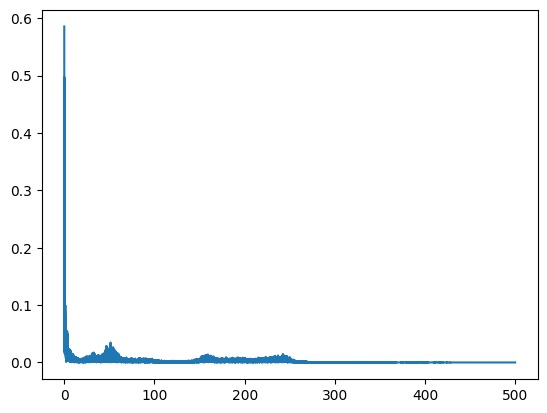

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = len(ax_values[16000:80000])
# sample spacing
T = 1.0 / 1000
x = np.linspace(0.0, N*T, N)
y = ax_values[16000:80000]
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

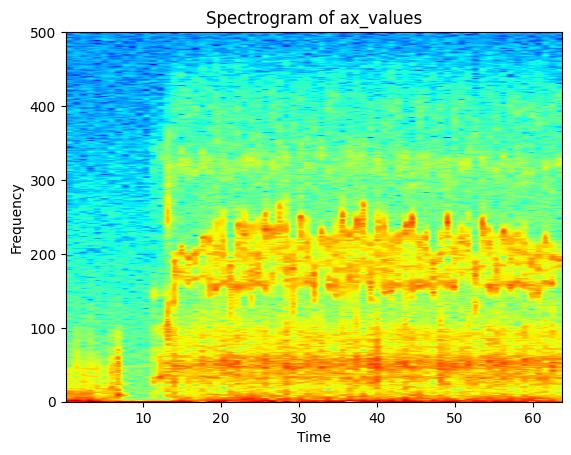

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming ax_values is your signal and Fs is your sampling frequency
Fs = 1000  # Replace with your actual sampling frequency

# Create figure and axis
fig, ax = plt.subplots()

# Create the spectrogram
ax.specgram(ax_values[16000:80000], NFFT=1024, Fs=Fs,cmap='jet')
# print(ax.specgram(ax_values[16000:80000], NFFT=1024, Fs=Fs,cmap='jet'))

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_title('Spectrogram of ax_values')

# Display the plot
plt.show()


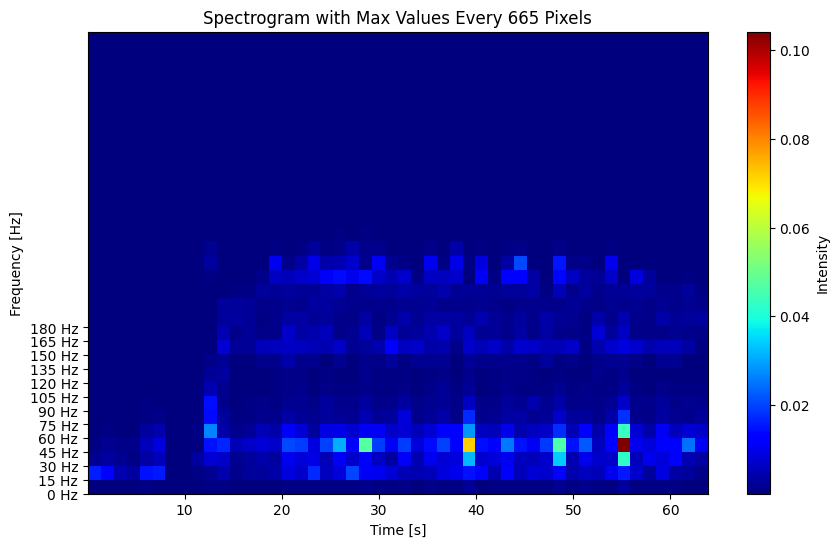

In [13]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
fs =1000 
def plot_max_spectrogram(audio_data, sample_rate, nfft=1024, noverlap=512, bin_size=665):
    """
    Generate and plot a spectrogram with maximum values for every bin_size pixels.

    Parameters:
    - audio_data: 1D array-like, the audio signal
    - sample_rate: int, the sample rate of the audio signal
    - nfft: int, number of data points used in each block for the FFT
    - noverlap: int, number of points of overlap between segments
    - bin_size: int, number of time bins to group together for max calculation
    -must nfft>noverlap, the ratio between nfft to nover lap make the resulotion of the graph
    """

    # Generate the spectrogram
    f, t, Sxx = spectrogram(audio_data, fs=sample_rate, nperseg=nfft, noverlap=noverlap)
    
    # Ensure the number of time bins is divisible by bin_size
    num_bins = Sxx.shape[1]
    remainder = num_bins % bin_size
    
    if remainder != 0 and num_bins >= bin_size:
        # If remainder exists and there are enough bins, truncate the last few columns
        Sxx = Sxx[:, :-remainder]
        t = t[:-remainder]

    if Sxx.shape[1] >= bin_size:
        # Take the maximum value for every bin_size pixels in the time dimension
        max_values = np.max(Sxx.reshape(Sxx.shape[0], -1, bin_size), axis=2)

        # Plot the spectrogram
        plt.figure(figsize=(10, 6))
        plt.imshow((max_values), aspect='auto', origin='lower', cmap='jet',
                   extent=[t.min(), t.max(), f.min(), f.max()])
        # plt.imshow(10 * np.log10(max_values), aspect='auto', origin='lower', cmap='jet',
        #            extent=[t.min(), t.max(), f.min(), f.max()])
        plt.colorbar(label='Intensity')
        plt.xlabel('Time [s]')
        plt.ylabel('Frequency [Hz]')
        plt.title(f'Spectrogram with Max Values Every {bin_size} Pixels')
        resonators_freqs1 = [0, 15, 30, 45, 60,75,90,105,120,135,150,165,180]
        # y_ticks = np.linspace(f.min(), f.max(), num=10)  # Example: 10 evenly spaced ticks
        y_labels = [f"{int(ytick)} Hz" for ytick in resonators_freqs1]  # Example: format labels as integers with "Hz"
        plt.yticks(resonators_freqs1, y_labels)
        
        plt.show()
    else:
        print(f"Error: The number of time bins ({Sxx.shape[1]}) is less than the bin size ({bin_size}). "
              "Adjust the bin size or the parameters to ensure sufficient bins.")

# Example usage:




plot_max_spectrogram(ax_values[16000:80000], fs, nfft=64, noverlap=62)

In [14]:
# 63450/50 = 1269